## Setup
- load train and test datasets, create TensorFlow Datasets from them
- define main architecutre params

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import absolute_import, division, print_function

import logging
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import skimage

from src.data_utils import Dataset
from src.network import unet_3d

# tf.enable_eager_execution()

# get TF logger - set it to info for more tracking process
log = logging.getLogger('tensorflow')
log.setLevel(logging.DEBUG)

BATCH_SIZE = 2
DEPTH = 3
N_BASE_FILTERS = 4
NUM_CLASSES = 3

WH = 128
MAX_DEPTH = 32
CLASS_WEIGHTS = np.array([0.00444413, 0.69519929, 0.30035659])

TRAIN_N = 70
TEST_N = 10
EPOCHS = 1

In [3]:
train_dataset = Dataset.load_dataset(
    '../data/processed/train_dataset.pckl'
).create_tf_dataset().shuffle(50).repeat().padded_batch(
    batch_size=BATCH_SIZE,
    padded_shapes=([MAX_DEPTH, WH, WH, 1], [MAX_DEPTH, WH, WH, NUM_CLASSES]))

test_dataset = Dataset.load_dataset(
    '../data/processed/test_dataset.pckl'
).create_tf_dataset().padded_batch(
    batch_size=1,
    padded_shapes=([MAX_DEPTH, WH, WH, 1], [MAX_DEPTH, WH, WH, NUM_CLASSES]))

# setup train and test dataset iterator objects
iterator = tf.data.Iterator.from_structure(
    train_dataset.output_types,
    train_dataset.output_shapes,
)
training_init_op = iterator.make_initializer(train_dataset, name='train_init_op')
test_init_op = iterator.make_initializer(test_dataset, name='test_init_op')

# first element is scans, second is target, i.e. segmentation
next_element = iterator.get_next()

In [4]:
# batch normalisation uses population mean/var at testing
train_phase = tf.placeholder(tf.bool, name="is_training")

# create the neural network model
logits = unet_3d(
    next_element[0],
    training=train_phase,
    depth=DEPTH,
    n_base_filters=N_BASE_FILTERS,
    num_classes=NUM_CLASSES
)


# weighted softmax, see https://stackoverflow.com/a/44563055
class_weights = tf.cast(tf.constant(CLASS_WEIGHTS), tf.float32)
class_weights = tf.reduce_sum(
    tf.cast(next_element[0], tf.float32) * class_weights, axis=-1
)
loss = tf.losses.softmax_cross_entropy(
    logits=logits,
    onehot_labels=next_element[1],
    weights=class_weights
)

# as per TF batch_norm docs and also following https://goo.gl/1UVeYK
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_op = tf.train.AdamOptimizer().minimize(loss)

# get mean IOU (channel last tensors)
prediction = tf.argmax(logits, axis=-1)
labels = tf.argmax(next_element[1], -1)
iou, conf_mat = tf.metrics.mean_iou(
    labels=labels,
    predictions=tf.cast(prediction, tf.int32),
    num_classes=NUM_CLASSES
)

tf.identity(prediction, 'prediction')
tf.identity(iou, 'iou')

# initialise session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
sess.run(training_init_op)
saver = tf.train.Saver()

# run the training
for i in range(EPOCHS * TRAIN_N):
    # get mean IOU, idea taken from: https://stackoverflow.com/a/46414395
    l, _, _, _ = sess.run([loss, train_op, iou, conf_mat],
                          feed_dict={train_phase: True})
    miou = sess.run([iou])
    if i % 50 == 0:
        log.info("Epoch: {}, loss: {:.3f}, training IOU: {:.3f}%".format(
            i, l, miou[0] * 100))

# re-initialize the iterator, but this time with test data
sess.run(test_init_op)
avg_miou = 0
for i in range(TEST_N):
    miou, pred = sess.run([iou, prediction], feed_dict={train_phase: False})
    avg_miou += miou

print(
    "Average test set IOU over {} iterations is {:.2f}%".format(
        TEST_N, (avg_miou / TEST_N) * 100))

save_path = saver.save(sess, "/tmp/model.ckpt")
print("Model saved in path: %s" % save_path)

DEBUG:tensorflow:conv1: (?, 32, 128, 128, 4)
DEBUG:tensorflow:conv2: (?, 32, 128, 128, 8)
DEBUG:tensorflow:maxpool layer: (?, 16, 64, 64, 8)
DEBUG:tensorflow:conv1: (?, 16, 64, 64, 8)
DEBUG:tensorflow:conv2: (?, 16, 64, 64, 16)
DEBUG:tensorflow:maxpool layer: (?, 8, 32, 32, 16)
DEBUG:tensorflow:conv1: (?, 8, 32, 32, 16)
DEBUG:tensorflow:conv2: (?, 8, 32, 32, 32)
DEBUG:tensorflow:upconv layer: (?, 16, 64, 64, 32)
DEBUG:tensorflow:concat layer: (?, 16, 64, 64, 16)
DEBUG:tensorflow:up_conv layer1: (?, 16, 64, 64, 16)
DEBUG:tensorflow:up_conv layer2 : (?, 16, 64, 64, 16)
DEBUG:tensorflow:upconv layer: (?, 32, 128, 128, 16)
DEBUG:tensorflow:concat layer: (?, 32, 128, 128, 8)
DEBUG:tensorflow:up_conv layer1: (?, 32, 128, 128, 8)
DEBUG:tensorflow:up_conv layer2 : (?, 32, 128, 128, 8)
DEBUG:tensorflow:output layer:: (?, 32, 128, 128, 3)
INFO:tensorflow:Epoch: 0, loss: 0.216, training IOU: 21.905%
INFO:tensorflow:Epoch: 50, loss: 0.053, training IOU: 20.533%
Average test set IOU over 10 iterati

In [7]:
import tensorflow as tf
saver = tf.train.import_meta_graph('/tmp/model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('/tmp/'))
graph = tf.get_default_graph()
test_init_op = graph.get_operation_by_name("test_data:0")
sess.run(test_init_op)
y_pred, y_true = sess.run([prediction, labels], feed_dict={train_phase: False})    

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


In [25]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

sess.run(test_init_op)
y_pred, y_true = sess.run([prediction, labels], feed_dict={train_phase: False})    


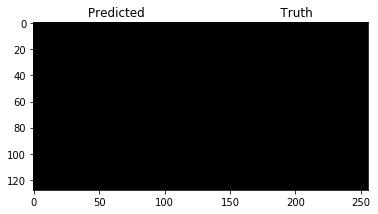

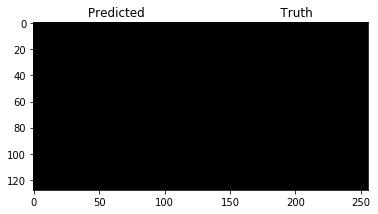

In [62]:
i = 1
p=y_pred[i] 
t=y_true[i]
ys = np.concatenate((p, t), axis=2)
fig, ax = plt.subplots()
for i, scan in enumerate(ys):
    plt.imshow(scan, cmap=plt.cm.bone)
    plt.title('Predicted                                   Truth')
    clear_output(wait=True)
    display(fig)
plt.show()